In [1]:
using PowerModels, Random, JuMP, Gurobi, DataFrames, Statistics
using CSV, DelimitedFiles
using Plots
const PM = PowerModels
PM.silence()

[info | PowerModels]: Suppressing information and warning messages for the rest of this session.  Use the Memento package for more fine-grained control of logging.


In [566]:
multiplier = 20;

In [567]:
file = "pglib_opf_case30_ieee__api.m";
data = parse_file(file);

In [568]:
# construct own data
scale = 100
buses = Dict{Int64,Dict}(v["bus_i"] => Dict{String, Set}("edges_in" => Set(Int[]),
                                                         "edges_out" => Set(Int[]),
                                                         "loads" => Set(Int[]),
                                                         "esrs" => Set(Int[]),
                                                         "gens" => Set(Int[])) for (_,v) in data["bus"])
branches = Dict{Int64, Dict}()
for (_,v) in data["branch"]
    local d = Dict{String, Any}("r" => v["br_r"], "x" => v["br_x"], "cap" => v["rate_a"] * scale, "f_bus" => v["f_bus"], "t_bus" => v["t_bus"], "angmin" => v["angmin"], "angmax" => v["angmax"])
    d["b"] = -imag(1 / (d["r"] + im * d["x"])) * scale
    push!(buses[d["f_bus"]]["edges_out"], v["index"])
    push!(buses[d["t_bus"]]["edges_in"], v["index"])
    branches[v["index"]] = d
end
gens = Dict{Int64, Dict}()
for (_,v) in data["gen"]
    if v["pmax"] > 0
        local d = Dict{String, Any}("cap" => v["pmax"] * scale, "bus" => v["gen_bus"], "ncost" => v["ncost"], "cost" => v["cost"] / scale)
        push!(buses[d["bus"]]["gens"], v["index"])
        gens[v["index"]] = d
    end
end
loads = Dict{Int64, Dict}()
for (_,v) in data["load"]
    local d = Dict{String, Any}("bus" => v["load_bus"], "cap" => v["pd"] * scale)
    push!(buses[d["bus"]]["loads"], v["index"])
    loads[v["index"]] = d
end

In [569]:
# add time-dependent data
# assume only load bid is dependent on time for now
T = 24
Random.seed!(0);
for (_,v) in loads
    set_point = v["cap"]
    perc = 0.5 * rand(T) .+ 0.75
    v["cap"] = set_point .* perc
end

# Assign bid information
for (k,v) in branches
    v["bid_cost"] = 0.1 / scale
end
for (k,v) in gens
    if v["ncost"] == 0
        v["bid_cost"] = 0
    else
        v["bid_cost"] = v["cost"][end-1]
    end
end
for (k,v) in loads
    v["bid_cost"] = repeat([20000.] / scale, T)
end


In [570]:
# add storage

# esr_nodes = Set([5, 12, 23])
# esr_nodes = [5, 15, 24]
esr_nodes = Set([24])
# esr_nodes = Set()
esr = Dict{Int64, Dict}()
idx = 1
for i in esr_nodes
    local d = Dict{String, Any}("bus" => i, "maxs" => 0.04 * multiplier * scale, "mins" => 0, "s0" => 0.02 * multiplier * scale, "pmax" => 0.01 * multiplier * scale, "η_c" => 0.95, "η_d" => 0.85)
    d["bid_cost_c"] = repeat([1000] / scale, T)
    d["bid_cost_d"] = repeat([1000] / scale, T)
    push!(buses[d["bus"]]["esrs"], idx)
    esr[idx] = d
    global idx += 1
end


In [571]:
# space-time market formulation (This is without robust bound!)
#=
nbus = length(buses);
nbranch = length(branches);
ngen = length(gens);
nload = length(loads);
# nvls = length(vls);
nesr = length(esr);

optimizer = optimizer_with_attributes(Gurobi.Optimizer, "OutputFlag" => 0)
m = Model(optimizer)

@variable(m, s[1:ngen, 1:T] >= 0)                      # supply
@variable(m, d[1:nload, 1:T] >= 0)                     # demand
@variable(m, ff[1:nbranch, 1:T] >= 0)                  # flow forward
@variable(m, fb[1:nbranch, 1:T] >= 0)                  # flow backward
@variable(m, θ[1:nbus, 1:T])
@variable(m, pc[1:nesr, 1:T] >= 0)                     # charging power
@variable(m, pd[1:nesr, 1:T] >= 0)                     # discharging power

bals = Dict()
for t in 1:T
    # Supply and demand capacity constraints
    for (k,v) in gens
        @constraint(m, s[k,t] <= v["cap"])
    end
    for (k,v) in loads
        @constraint(m, d[k,t] <= v["cap"][t])
    end

    # Flow capacity constraints & DC power flow equations
    for (k,v) in branches
        @constraint(m, ff[k,t] <= v["cap"])
        @constraint(m, fb[k,t] <= v["cap"])
        @constraint(m, ff[k,t] - fb[k,t] == v["b"] * (θ[v["f_bus"],t] - θ[v["t_bus"],t]))
    end

    # storage constraints
    for (k,v) in esr
        @constraint(m, v["mins"] - v["s0"] <= v["η_c"] * sum(pc[k,1:t]) - 1/v["η_d"] * sum(pd[k,1:t]) <= v["maxs"] - v["s0"])
        @constraint(m, pc[k,t] + pd[k,t] <= v["pmax"])
    end

    # Node balance constraint
    for (k,v) in buses
        bals[(k,t)] = @constraint(m, sum(s[i,t] for i in buses[k]["gens"]) - sum(d[i,t] for i in buses[k]["loads"])
                               + sum(ff[i,t] for i in buses[k]["edges_in"]) - sum(ff[i,t] for i in buses[k]["edges_out"])
                               - sum(fb[i,t] for i in buses[k]["edges_in"]) + sum(fb[i,t] for i in buses[k]["edges_out"]) 
                               + sum(pd[i,t] - pc[i,t] for i in buses[k]["esrs"])
                               == 0)
    end
end
for (k,v) in esr
    @constraint(m, v["η_c"] * sum(pc[k,1:T]) - 1/v["η_d"] * sum(pd[k,1:T]) >= 0)
end

# Objecitve: social welfare
@objective(m, Min, sum(sum(s[i,t] * gens[i]["bid_cost"] for i in 1:ngen) 
                       - sum(d[i,t] * loads[i]["bid_cost"][t] for i in 1:nload) 
                       + sum((ff[i,t] + fb[i,t]) * branches[i]["bid_cost"] for i in 1:nbranch) 
                       + sum(pc[i,t] * esr[i]["bid_cost_c"][t] + pd[i,t] * esr[i]["bid_cost_d"][t] for i in 1:nesr) for t in 1:T));
=#

In [572]:
#=
optimize!(m)

prices = zeros(nbus, T)
for i in 1:nbus, t in 1:T
    prices[i,t] = dual(bals[(i,t)])
end
prices_df = DataFrame(prices, [Symbol("T$(i)") for i in 1:T])
# display(prices_df)
println(objective_value(m))
=#

In [573]:
#=
for i in 1:nesr
    for t in 1:T
        if value(pc[i,t])*value(pd[i,t]) > 0
            println("Complementarity violated for ESR $(i) at time $(t).")
        end
#         println("ESR $(i) at time $(t): pc: $(value(pc[i,t])); pd: $(value(pd[i,t]))")
    end
end
=#

In [574]:
# Set up virtual links
vls = Dict{Int64, Dict}()
esr_to_in_vls = Dict{Int64, Dict}(i => Dict(t => Int64[] for t in 1:T) for (i,_) in esr)
esr_to_out_vls = Dict{Int64, Dict}(i => Dict(t => Int64[] for t in 1:T) for (i,_) in esr)
ct = 1
for (i,b) in esr
    for ts in 1:T
        for td in (ts+1):T
            α_δ = b["bid_cost_c"][ts] + b["η_c"]*b["η_d"]*b["bid_cost_d"][td]
            local d = Dict("bid_cost" => α_δ, "source" => ts, "dest" => td, "esr_idx" => i)
            vls[ct] = d
            push!(esr_to_in_vls[i][td], ct)
            push!(esr_to_out_vls[i][ts], ct)
            ct += 1
            α_δ = b["bid_cost_c"][td] + b["η_c"]*b["η_d"]*b["bid_cost_d"][ts]
            local d = Dict("bid_cost" => α_δ, "source" => td, "dest" => ts, "esr_idx" => i)
            vls[ct] = d
            push!(esr_to_in_vls[i][ts], ct)
            push!(esr_to_out_vls[i][td], ct)
            ct += 1
        end
    end
end

In [575]:
nbus = length(buses);
nbranch = length(branches);
ngen = length(gens);
nload = length(loads);
nvls = length(vls);
nesr = length(esr);

optimizer = optimizer_with_attributes(Gurobi.Optimizer, "OutputFlag" => 0)
m = Model(optimizer)

@variable(m, s[1:ngen, 1:T] >= 0)                      # supply
@variable(m, d[1:nload, 1:T] >= 0)                     # demand
@variable(m, ff[1:nbranch, 1:T] >= 0)                  # flow forward
@variable(m, fb[1:nbranch, 1:T] >= 0)                  # flow backward
@variable(m, θ[1:nbus, 1:T])
@variable(m, δ[1:nvls] >= 0)
@variable(m, pnc[1:nesr, 1:T] >= 0)
@variable(m, pnd[1:nesr, 1:T] >= 0)

bals = Dict()
for t in 1:T
    # Supply and demand capacity constraints
    for (k,v) in gens
        @constraint(m, s[k,t] <= v["cap"])
    end
    for (k,v) in loads
        @constraint(m, d[k,t] <= v["cap"][t])
    end

    # Flow capacity constraints & DC power flow equations
    for (k,v) in branches
        @constraint(m, ff[k,t] <= v["cap"])
        @constraint(m, fb[k,t] <= v["cap"])
        @constraint(m, ff[k,t] - fb[k,t] == v["b"] * (θ[v["f_bus"],t] - θ[v["t_bus"],t]))
    end

    # storage constraints
    for (k,v) in esr
        @constraint(m, v["η_c"] * sum(sum(δ[esr_to_out_vls[k][s]] - δ[esr_to_in_vls[k][s]]) for s in 1:t) >= v["mins"] - v["s0"] + 1/v["η_d"]*sum(pnd[k,1:t]))
        @constraint(m, v["η_c"]/v["η_d"] * sum(sum(δ[esr_to_out_vls[k][s]])-v["η_c"]*v["η_d"]*sum(δ[esr_to_in_vls[k][s]]) for s in 1:t) <= v["maxs"] - v["s0"] -  v["η_c"]*sum(pnd[k,1:t]))
        @constraint(m, pnc[k,t] + pnd[k,t] + sum(δ[esr_to_out_vls[k][t]]) + v["η_c"]*v["η_d"]*sum(δ[esr_to_in_vls[k][t]]) <= v["pmax"])
    end

    # Node balance constraint
    for (k,v) in buses
        bals[(k,t)] = @constraint(m, sum(s[i,t] for i in buses[k]["gens"]) - sum(d[i,t] for i in buses[k]["loads"])
                               + sum(ff[i,t] for i in buses[k]["edges_in"]) - sum(ff[i,t] for i in buses[k]["edges_out"])
                               - sum(fb[i,t] for i in buses[k]["edges_in"]) + sum(fb[i,t] for i in buses[k]["edges_out"]) 
                               + sum(pnd[i,t] - pnc[i,t] for i in buses[k]["esrs"])
                               + sum(esr[i]["η_c"]*esr[i]["η_d"]*sum(δ[esr_to_in_vls[i][t]]) for i in buses[k]["esrs"])
                               - sum(sum(δ[esr_to_out_vls[i][t]]) for i in buses[k]["esrs"])
                               == 0)
    end
end
for (k,v) in esr
    @constraint(m, v["η_c"] * sum(sum(δ[esr_to_out_vls[k][s]] - δ[esr_to_in_vls[k][s]]) for s in 1:T) >= 1/v["η_d"]*sum(pnd[k,1:T]))
end

# Objecitve: social welfare
@objective(m, Min, sum(sum(s[i,t] * gens[i]["bid_cost"] for i in 1:ngen) 
                       - sum(d[i,t] * loads[i]["bid_cost"][t] for i in 1:nload) 
                       + sum((ff[i,t] + fb[i,t]) * branches[i]["bid_cost"] for i in 1:nbranch) 
                       + sum(pnc[i,t] * esr[i]["bid_cost_c"][t] + pnd[i,t] * esr[i]["bid_cost_d"][t] for i in 1:nesr) for t in 1:T)
                       + sum(δ[i]*vls[i]["bid_cost"] for i in 1:nvls) );


Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-02-11


In [576]:
optimize!(m)
println(objective_value(m))

-1.840560850000627e6


In [577]:
prices = zeros(nbus, T)
for i in 1:nbus, t in 1:T
    prices[i,t] = dual(bals[(i,t)])
end
prices_df = DataFrame(prices, [Symbol("T$(i)") for i in 1:T])

,T1,T2,T3,T4,T5,T6,T7,T8,T9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,18.4215,18.4215,18.4215,18.4215,18.4215,18.4215,18.4215,18.4215,18.4215
2,52.1823,52.1823,52.1823,52.1823,52.1823,52.1823,52.1823,52.1823,52.1823
3,58.7125,36.3771,37.622,61.0211,37.622,37.622,36.3772,37.622,37.622
4,68.3562,40.6752,42.218,71.2173,42.218,42.218,40.6753,42.218,42.218
5,185.055,49.4987,48.5216,200.0,48.5216,48.5216,49.4987,48.5216,48.5216
6,81.4386,46.6148,44.5888,85.4722,44.5888,44.5888,46.6148,44.5888,44.5888
7,123.217,47.7778,46.1747,131.65,46.1747,46.1747,47.7777,46.1747,46.1747
8,81.4103,46.8555,44.5846,85.441,44.5846,44.5846,46.8555,44.5843,44.5846
9,79.3504,55.117,44.211,83.197,44.2111,44.2112,55.1169,44.2112,44.2112


In [578]:
CSV.write("prices_$(multiplier)_single3.csv", prices_df, header=false)

"prices_20_single3.csv"

In [504]:
for t in 1:T
    for i in 1:nesr
        b = esr[i]["bus"]
        if value(pnc[i,t]) > 0
            println("Net-charging by ESR $(b) occurs at t = $(t) with power $(value(pnc[i,t]))")
            println("    Payment: ", value(pnc[i,t]) * df.prices[b,t])
        end
        if value(pnd[i,t]) > 0
            println("Net-discharging by ESR $(b) occurs at t = $(t) with power $(value(pnd[i,t]))")
            println("    Remuneration: ", value(pnd[i,t]) * df.prices[b,t])
        end
    end
end

In [505]:
vl_df = DataFrame(:esr => Int64[], :ts => Int64[], :td => Int64[], :δ => Float64[], :πc => Float64[], :πd => Float64[], :profit => Float64[])
for (i,v) in vls
    if value(δ[i]) > 0
        esri = vls[i]["esr_idx"]
        bus = esr[esri]["bus"]
        ts = vls[i]["source"]
        td = vls[i]["dest"]
        val = value(δ[i])
        cprice = prices[bus, ts]
        dprice = prices[bus, td]
        η_c, η_d = esr[esri]["η_c"], esr[esri]["η_d"]
        profit = (η_c*η_d*dprice-cprice)*val
        push!(vl_df, [esri, ts, td, val, cprice, dprice, profit])
    end
end

In [506]:
p1 = sum(vl_df[vl_df[!,:esr] .== 1, :profit])
p2 = sum(vl_df[vl_df[!,:esr] .== 2, :profit])
p3 = sum(vl_df[vl_df[!,:esr] .== 3, :profit])
println("Total profit for ESR 1: ", p1)
println("Total profit for ESR 2: ", p2)
println("Total profit for ESR 3: ", p3)

Total profit for ESR 1: 2438.417068299048
Total profit for ESR 2: 0.0
Total profit for ESR 3: 0.0


In [507]:
if !@isdefined profits3_alone
    profits3_alone = Float64[]
end
push!(profits3_alone, p1)

7-element Vector{Float64}:
  875.3592776694932
 1884.8884245279046
 2438.417068299047
 2438.4170682990475
 2438.417068299047
 2438.4170682990475
 2438.417068299048

In [135]:
# Record the results
if !@isdefined profits_df
    profits_df = DataFrame(:multiplier => Int64[], :profit1 => Float64[], :profit2 => Float64[], :profit3 => Float64[])
end
if !(multiplier in profits_df[!, :multiplier])
    push!(profits_df, [multiplier, p1, p2, p3])
end

# sort if needed
sort!(profits_df, [:multiplier])

,multiplier,profit1,profit2,profit3
,Int64,Float64,Float64,Float64
1,1,559.645,513.422,238.766
2,5,2198.43,513.781,404.374
3,10,4228.58,771.881,791.799
4,15,4599.55,946.111,808.689
5,20,5258.2,216.362,682.194
6,25,1459.53,245.123,0.0
7,50,1459.53,245.123,0.0


In [512]:
profits_df

,multiplier,profit1,profit2,profit3,profits1_single,profits2_single,profits3_single
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,559.645,513.422,238.766,1678.94,1140.48,875.359
2,5,2198.43,513.781,404.374,4599.55,1218.62,1884.89
3,10,4228.58,771.881,791.799,1459.53,1218.61,2438.42
4,15,4599.55,946.111,808.689,1459.53,1218.61,2438.42
5,20,5258.2,216.362,682.194,1459.53,1218.61,2438.42
6,25,1459.53,245.123,0.0,1459.53,1218.61,2438.42
7,50,1459.53,245.123,0.0,1459.53,1218.61,2438.42


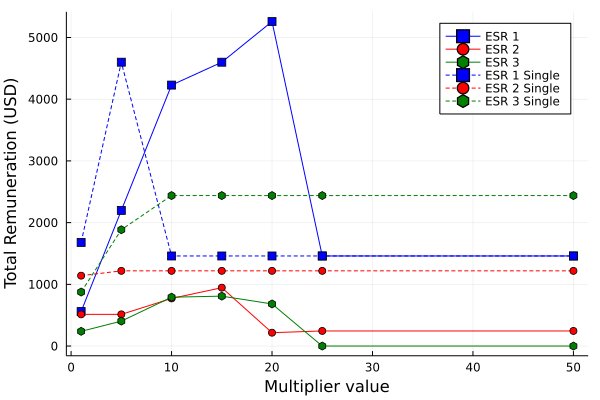

In [579]:
plot(profits_df[!, :multiplier], profits_df[!, :profit1], linecolor = :blue, markercolor = :blue, markershape = :square, label = "ESR 1")
plot!(profits_df[!, :multiplier], profits_df[!, :profit2], linecolor = :red, markercolor = :red, markershape = :circle, label = "ESR 2")
plot!(profits_df[!, :multiplier], profits_df[!, :profit3], linecolor = :green, markercolor = :green, markershape = :hexagon, label = "ESR 3")
plot!(profits_df[!, :multiplier], profits_df[!, :profits1_single], linecolor = :blue, markercolor = :blue, linestyle = :dash, markershape = :square, label = "ESR 1 Single")
plot!(profits_df[!, :multiplier], profits_df[!, :profits2_single], linecolor = :red, markercolor = :red, linestyle = :dash, markershape = :circle, label = "ESR 2 Single")
plot!(profits_df[!, :multiplier], profits_df[!, :profits3_single], linecolor = :green, markercolor = :green, linestyle = :dash, markershape = :hexagon, label = "ESR 3 Single")
plot!(xlabel = "Multiplier value", ylabel = "Total Remuneration (USD)")
# savefig("profits_v2.pdf")